### **Introduction**

Kaggle's **Titanic - Machine Learning from Disaster** is a classic introductory problem for getting familiar with the fundamentals of machine learning. Here's a quick run-through on how I tuned some features to improve a model.


### **Where to start?**

https://www.kaggle.com/code/alexisbcook/titanic-tutorial/notebook

Alexis provides a brief introduction for making a submission to kaggle with some sample code for this challenge. She uses a random forest classifier for the model in her example.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import os

PATH = "../input/titanic/" # file path to the datasets

for dirname, _, filenames in os.walk('PATH'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Load Datasets

In [15]:
### Load Datasets
train_data = pd.read_csv(PATH + "train.csv")
test_data = pd.read_csv(PATH + "test.csv")

In [16]:
y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

### Results
The submission of this model resulted in a score of 0.77511

### **Contribution**
<!-- We can start with this as our baseline and change a few things to see if we 
get a better result. The first and easisest thing to do is tune the hyperparameters for the Random Forest Classifier and compare the results with the original submission. -->

We can start by looking for entries in the dataset to dropout or modify to improve the performance of the model. The passenger ID contains a unique and non-null value which means that there will be no duplicates to drop. There are missing values in other columns that we can explore.

In [17]:
data_list = [train_data.drop("Survived", axis=1), test_data]
data_list = [train_data, test_data]
for i, dl in enumerate(data_list):
        data_list[i].Sex = dl.Sex.apply(lambda sex: 0 if sex == "male" else 1)
all_data = pd.concat(data_list)

missing_vals = [all_data[col].isnull().sum() for col in all_data.columns.to_list()]
labels = all_data.columns.to_list()
ser = pd.Series(data=missing_vals, index=labels, name="by amount")
ser_missing = ser[ser > 0].drop("Survived", axis=0)

percentages = ser_missing.apply(lambda x: "%.2f " % (x * 100 / all_data.shape[0]))
percentages.name = "by percent"
print(f"Total number of rows: {all_data.shape[0]}\n\n{ser_missing} \
        \n\n{percentages}")
plt.show()


Total number of rows: 1309

Age          263
Fare           1
Cabin       1014
Embarked       2
Name: by amount, dtype: int64         

Age         20.09 
Fare         0.08 
Cabin       77.46 
Embarked     0.15 
Name: by percent, dtype: object


Since the number of missing values for `Fare` and `Embarked` column is negligible, it is best to simply drop these entries from the dataset. However, there are a considerable amount of missing values for the `Age` and `Cabin` columns. A naive approach for filling in the missing values for the columns would be to fill them in with the mean, median, or mode of the column. The better approach is to look at the relationships between `Age` and the other columns, then determine how to replace the missing values. We can apply the same principle for the `Cabin` column.

The format of the cabin data will need to be changed. The cabin data is given as `{Cabin Type}{Room Number}`. The room number can be discarded but since the cabin type likely has some influence on rather a passenger survives, it should be included. To check this, we'll look at the relationship between the cabin type and survival

In [18]:
pd.options.mode.chained_assignment = None
### Note: You would drop the Fare and Embarked null values
    # dl = dl[dl["Fare"].notna() & dl["Embarked"].notna()]
    # but for the competition these entries are required.

    # I'll fill the `Fare` Column in with the median
    # and bin the values for the `Fare` Column.
for i, dl in enumerate(data_list):
    dl["Fare"] = dl["Fare"].fillna(dl["Fare"].median())
    dl["Fare"] = pd.qcut(dl["Fare"], q=4, labels=['A','B','C','D'])

    dl["Embarked"] = dl["Embarked"].fillna("S")
    dl["Cabin"] = dl["Cabin"].apply(lambda x: x[0] if pd.notna(x) else x)
    dl["Cabin"] = dl["Cabin"].astype('category').cat.codes
    data_list[i] = dl
all_data = pd.concat(data_list)

corr = all_data.corr()[["Age", "Cabin"]].drop("PassengerId", axis=0)
print(corr)

               Age     Cabin
Survived -0.077221  0.287944
Pclass   -0.408106 -0.563667
Sex      -0.063645  0.133479
Age       1.000000  0.205097
SibSp    -0.243699 -0.009317
Parch    -0.150917  0.034465
Cabin     0.205097  1.000000


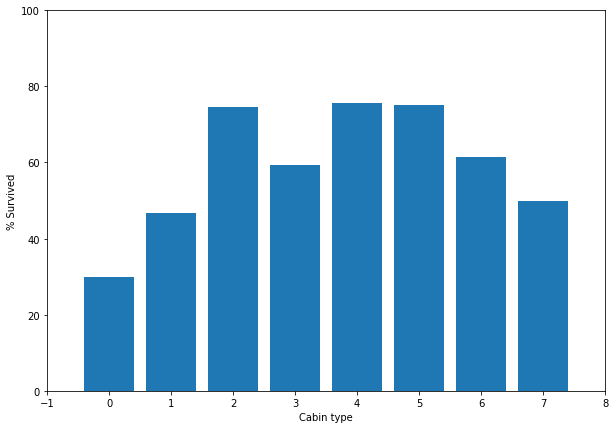

In [19]:
train_data_copy = train_data.copy()
train_data_copy["Cabin"] = train_data_copy["Cabin"].astype('category').cat.codes
group_survive = train_data_copy.groupby("Cabin")["Survived"].sum()
goup_count = train_data_copy.groupby("Cabin")["Survived"].count()

percentages = []
for (u, v) in zip(group_survive, goup_count):
    percentages.append(u / v * 100)

fig = plt.figure(figsize =(10, 7))
plt.bar(group_survive.index, percentages)
plt.xlabel("Cabin type")
plt.ylabel("% Survived")
plt.axis([-1, 8, 0, 100])
plt.show()

`Pclass` appears to have a high influence on `Age` and `Cabin` column. This information can be applied to extract finer approximations based on the `Pclass` to replace the missing entries as opposed to a "one fits all" approximation.

In [7]:
age_group = all_data.groupby(["Pclass"])["Age"].mean().astype(int)
cabin_group = all_data.groupby(["Cabin"])["Pclass"].agg(pd.Series.mode)

for i in all_data[all_data["Age"].isna()].index:
    Pclass = all_data.iloc[i].Pclass
    all_data.loc[i, "Age"] = round(age_group[Pclass])
    
cabin_group

Cabin
-1    3
 0    1
 1    1
 2    1
 3    1
 4    1
 5    2
 6    3
 7    1
Name: Pclass, dtype: int64

Looking at the % survived chart and how the `Cabin` relates to `Pclass`, we can reasonably assume that cabin 1, 3, 4, are roughly the same. We'll bin these cabins and the remaining cabins will go in a seperate bin. A `PClass` of 1 will belong to the first bin and anything else belongs to the second bin.

In [8]:
all_data['Cabin'] = all_data['Cabin'].replace([1,3,4], 0)
all_data['Cabin'] = all_data['Cabin'].replace([0,2,5,6,7], 1)
for i in all_data[all_data["Cabin"] == -1].index:
    Pclass = all_data.iloc[i].Pclass
    all_data.loc[i, "Cabin"] = 0 if Pclass == 1 else 1

missing_vals = [all_data[col].isnull().sum() for col in all_data.columns.to_list()]
labels = all_data.columns.to_list()
ser = pd.Series(data=missing_vals, index=labels, name="by amount").drop("Survived", axis=0)
ser

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Name: by amount, dtype: int64

Now that there are no more missing values, we can add the `Age` and `Cabin` columns to the features for the original model.

In [9]:
def train(features):
    train_data = all_data[all_data["Survived"].notna()]
    test_data = all_data[all_data["Survived"].isna()]

    y = train_data["Survived"]

    X = pd.get_dummies(train_data[features])
    X_test = pd.get_dummies(test_data[features])


    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
    model.fit(X, y)
    predictions = model.predict(X_test)

    output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions.astype(int)})
    output.to_csv('new_submission.csv', index=False)

### **Scores**
Original Score: 0.77511

In [10]:
train(["Pclass", "Sex", "SibSp", "Parch", "Cabin", "Age"])

Score 0.78468

In [12]:
train(["Pclass", "Sex", "SibSp", "Parch", "Age", "Fare", "Embarked"])

Score: 0.78708

In [13]:
train(["Pclass", "Sex", "SibSp", "Parch", "Fare", "Embarked"])

Score: 0.76555

### **Conclusion**

Without tuning any of the hyperparameters for the given model, I was able to slightly improve the model by including some of the features that were initially incompatible with the `Random Forest Classifier`. Adding just `Fare` and `Embarked` resulted in a lower score. Additionally, removing `Cabin` and including the rest of the features resulted in the best score. Doing further data analysis and engineering on the features may result in meaningful changes to the scores, but changing the hyperparameters for the RFC or experimenting with other types of models is likely the better approach to improving the scores at this point.